# Modelado Matemático - Análisis de una galaxia - Parte 1

**Carlos Andrés Bautista Torres**

código: 2208057

<img src="auxiliares\portada.jpg" width="150%" align="center" >





In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
#from mpl_toolkits.axes_grid1 import make_axes_locatable

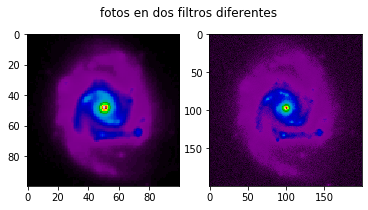

In [2]:
ban1 = fits.open("auxiliares/ban_1.fits")
ban2 = fits.open("auxiliares/ban_2.fits")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
fig.suptitle('fotos en dos filtros diferentes')
ax1.imshow(ban1[0].data, cmap='nipy_spectral')
ax2.imshow(ban2[0].data, cmap='nipy_spectral')


## -------------------- Tratamiento de datos para el filtro con menor resolución --------------------

### Lo que se verá a continuación es exactamente el mismo tratamiento de datos que se realizó para la imagen de mayor resolución. 


In [3]:
corte_A_2 = ban1[0].data[:,:] # Coje los datos y los recorta. El primer par es en el eje y
corte_A_2 = corte_A_2/corte_A_2.sum() # Normaliza los datos por la suma.
corte_noise = corte_A_2[0:25,0:25]
histograma = np.histogram(corte_noise)
histograma

(array([174, 275,  87,  30,  24,  14,  11,   5,   3,   2]),
 array([-2.85663396e-06,  1.77749382e-06,  6.41162160e-06,  1.10457495e-05,
         1.56798778e-05,  2.03140044e-05,  2.49481327e-05,  2.95822610e-05,
         3.42163876e-05,  3.88505177e-05,  4.34846443e-05], dtype=float32))

In [4]:
for i in np.arange(corte_A_2.shape[0]):
    for j in np.arange(corte_A_2.shape[1]):
        corte_A_1 = np.zeros(corte_A_2.shape)
        if corte_A_2[i,j] <= 1.77749382e-06:
            corte_A_2[i,j] = 0


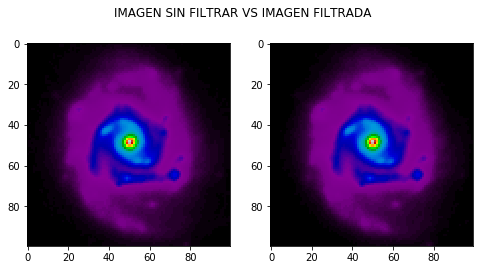

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(8,4))
fig.suptitle('IMAGEN SIN FILTRAR VS IMAGEN FILTRADA')

plt.subplot(1, 2, 1)
plt.imshow(ban1[0].data, cmap='nipy_spectral')

plt.subplot(1, 2, 2)
plt.imshow(corte_A_2, cmap='nipy_spectral')


### El modelo que se usará inicialmente es el exponencial, de la forma

$A= A_0 e^{\sqrt{(x-x_0)^2+(y-y_0)^2}/h},$

### siendo $A_0$, $x_0$, $y_0$ y $h$, los parámetros a optimizar. Pero la galaxia no está completamente de frente a la cámara, por lo que primero es necesario determinar dicho ángulo de inclinación. Para ello se usarán dos métodos, el primero mediante un modelo elipsoidal.

## -------------------------------------MODELO ELIPSOIDAL -------------------------------------


### Si la galaxia no está completamente de frente a la cámara, podemos considerar la inclinación de la galaxia a partir de un modelo exponencial elipsoidal. Recordemos que la ecuación de una elipse es
$\left(\frac{(x-x_0)}{a}\right)^2 + \left(\frac{(y-y_0)}{b}\right)^2 = 1\:,$

### lo cual permitiría tener una dispersión entre el los dos ejes $x$ y $y$. Teniendo en cuenta lo anterior, se propone una exponencial de la forma
$A = A_0 e^{\sqrt{\frac{(x-x_0)^2}{a^2} + \frac{(y-y_0)^2}{b^2}}/h} = A_0 e^{\sqrt{\frac{(x-x_0)^2}{h_1} + \frac{(y-y_0)^2}{h_2}}}$ 

### con $h_1 = (ah)^2$ y $h_2= (bh)^2$.

In [6]:
def make_expoelipse(tpl,image):  # Recibe un set de parámetros para hacer la gaussiana y el tamaño de la img.
    expo = np.zeros(image.size)   # Inicializa la matriz donde quedará la gaussiana.
    x = np.arange(image.shape[0]) # Toma el número de columnas de la matrz.imag y crea un arreglo x. 
    y = np.arange(image.shape[1]) # Toma el número de filas de la matrz.imag y crea un arreglo y.
    xx,yy = np.meshgrid(x,y)      # Crea la malla donde se pondrá la gaussiana.
    x0 = tpl[0] # Toma el primer valor del vector parámetros, y lo atribuye al centro de la función en x.
    y0 = tpl[1] # Toma el segundo valor del vector parámetros, y lo atribuye al centro de la función en y.
    A = tpl[2]  # Toma el tercer valor del vector parámetros, y lo atribuye a la aplitud de la función.
    h1 = tpl[3]  # Toma el cuarto valor del vector parámetros, y lo atribuye a la escala "h" de la función.
    h2 = tpl[4]
    expo = A*np.exp(-(np.sqrt((xx-x0)**2/h1 + (yy-y0)**2/h2))) # Se plantea la gaussiana.
    #expo = expo/expo.sum() # Se normaliza por el total de datos.
    return expo

In [7]:
def ErrorFunc2(tpl,image): # Misma entrada que make_gaussian.
    expo = make_expoelipse(tpl,image) # Saca una gaussiana con el set de parámetros que se le ingresaron.
    chi = np.ravel((image-expo)) # Resta los datos reales con los del modelo gaussiano.
    return chi

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


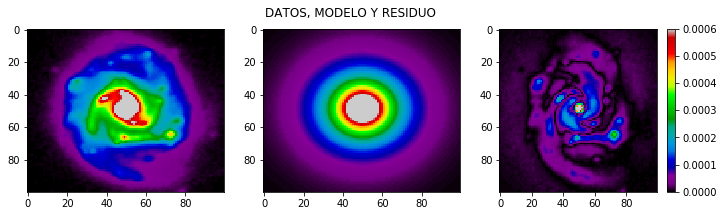

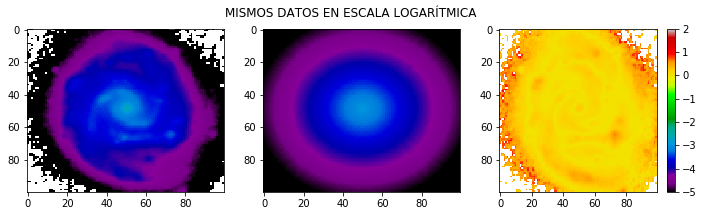

In [8]:
x0  = corte_A_2.shape[0]/2 # Da un punto en x inicial para que luego se optimice.
y0  = corte_A_2.shape[1]/2 # Da un punto inicial el y para optimizar.
A   = corte_A_2.max()
h1  = 20 # Elije un valor a priori para la dispersión en x.
h2  = 20
p1 = [x0,y0,A,h1,h2] # Pone los parámetros en un vector, (será un parámetro de las funciones siguientes).
best_params2,success = leastsq(ErrorFunc2, p1, args = (corte_A_2)) # leastsq función que optimiza los parámetros.
g3 = make_expoelipse(best_params2,corte_A_2)

# !!!!!!!!!!!!!!!!!!!!!!!!!!! PLOTEADA DE DATOS !!!!!!!!!!!!!!!!!!!!!!!!!!!
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('DATOS, MODELO Y RESIDUO')

plt.subplot(1, 3, 1)
plt.imshow(corte_A_2, vmin=0, vmax=0.0006, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(g3, vmin=0, vmax=0.0006, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(corte_A_2 - g3), vmin=0, vmax=0.0006, cmap='nipy_spectral', aspect='auto')
plt.colorbar()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('MISMOS DATOS EN ESCALA LOGARÍTMICA')

plt.subplot(1, 3, 1)
plt.imshow(np.log10(corte_A_2), vmin=-5, vmax=2, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(np.log10(g3), vmin=-5, vmax=2, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(np.log10(corte_A_2) - np.log10(g3)), vmin=-5, vmax=2, cmap='nipy_spectral', aspect='auto')
plt.colorbar()

### Aunque aparentemente parece ser el mismo resultado, hay una ligera diferencia que se puede observar a través de los parámetros optimizados. 

In [9]:
print("dispersión en x ~", np.sqrt(best_params2[3]), "& dispersión en y ~", np.sqrt(best_params2[4]))

dispersión en x ~ 11.184154978087005 & dispersión en y ~ 11.549888254422966


### Lo anterior implica que si la galaxia es circular, entonces está casi de frente a la lente de la cámara. Para determinar el ángulo de inclinación se utilizan los parámetros $h_1$ y $h_2$,

$ \frac{h_1}{h_2} = \frac{(ah)^2}{(bh)^2} = \frac{a^2}{b^2} \:\: \rightarrow \:\: cos(i) = \frac{a}{b} = \sqrt{h_1/h_2}$

In [10]:
cos_i = np.sqrt(best_params2[3]/best_params2[4])
i = np.arccos(cos_i)
print("el coseno del ángulo es", cos_i, "y el ángulo en grados sexagecimales es", i*180/np.pi)

el coseno del ángulo es 0.9683344749075035 y el ángulo en grados sexagecimales es 14.457183803921737


## --------------------------------- PERFIL 1D EN X & Y---------------------------------

### Hay otro método que se si bien es algo manual, permite obtener una segunda medida del ángulo de inclinación que incluso puede ser más exacta que la obtenida anteriormente, pues debido a que el modelo intenta ajustar varios parámetros a la vez, no solo la dispersión en x & y, estas podrían verse alteradas.

In [11]:
print(corte_A_2.max(), np.where(corte_A_2 == corte_A_2.max()))

0.0022623849 (array([48]), array([50]))


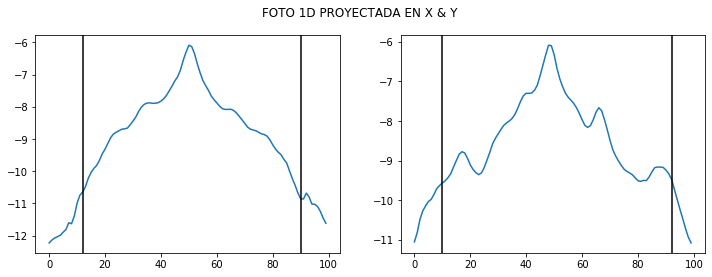

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(12,4))
fig.suptitle('FOTO 1D PROYECTADA EN X & Y')

plt.subplot(1, 2, 1)
plt.plot(np.arange(corte_A_2.shape[1]), np.log(corte_A_2[48,:]))
plt.axvline(x=12, color='black')
plt.axvline(x=90, color='black')


plt.subplot(1, 2, 2)
plt.plot(np.arange(corte_A_2.shape[1]), np.log(corte_A_2[:,50]))
plt.axvline(x=10, color='black')
plt.axvline(x=92, color='black')

### Se puede observar un buen comportamiento exponencial en el centro de la galaxia, sin embargo a medida que se aleja del centro la función se torna inestable. Incluso se puede observar en la gráfica de la derecha tres picos más asociados con los brazos de la galaxia.

### En este caso se obtiene que 
$a = \frac{90-12}{2} = 39 \:\:\: \text{&}\:\:\: b = \frac{92-10}{2} = 41 \:\:\: \rightarrow \:\: cos(i) = \frac{a}{b} = \frac{39}{41} = 0.951$ 

### entonces para considerar ambos resultados, lo más conveniente es promediarlos, dando como resultado
$cos(i) = \frac{0.968 + 0.951}{2} = 0.96$

### Ahora es necesario plantear el modelo exponencial el cual se piensa inclinar un ángulo $i$ para posteriormente cotejar con los datos. Para inclinar el modelo exponencial se debe tener en cuenta que el eje x está modificado por un factor de $cos(i)$

$A = A_0 e^{\frac{1}{h}\sqrt{\left(\frac{x-x_0}{cos(i)}\right)^2+(y-y_0)^2}},$



In [13]:
def make_inc_exponential(tpl,image):  # Recibe un set de parámetros para hacer la gaussiana y el tamaño de la img.
    expo = np.zeros(image.size)   # Inicializa la matriz donde quedará la gaussiana.
    x = np.arange(image.shape[0]) # Toma el número de columnas de la matrz.imag y crea un arreglo x. 
    y = np.arange(image.shape[1]) # Toma el número de filas de la matrz.imag y crea un arreglo y.
    xx,yy = np.meshgrid(x,y)      # Crea la malla donde se pondrá la gaussiana.
    x0 = tpl[0] # Toma el primer valor del vector parámetros, y lo atribuye al centro de la función en x.
    y0 = tpl[1] # Toma el segundo valor del vector parámetros, y lo atribuye al centro de la función en y.
    A = tpl[2]  # Toma el tercer valor del vector parámetros, y lo atribuye a la aplitud de la función.
    h = tpl[3]  # Toma el cuarto valor del vector parámetros, y lo atribuye a la escala "h" de la función.
    expo = A*np.exp(-(np.sqrt((xx-x0)**2/0.96**2 + (yy-y0)**2))/h) # Se plantea la gaussiana.
    #expo = expo/expo.sum() # Se normaliza por el total de datos.
    return expo

In [14]:
def ErrorFunc(tpl,image): # Misma entrada que make_gaussian.
    expo = make_inc_exponential(tpl,image) # Saca una gaussiana con el set de parámetros que se le ingresaron.
    chi = np.ravel((image-expo)) # Resta los datos reales con los del modelo gaussiano.
    return chi

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


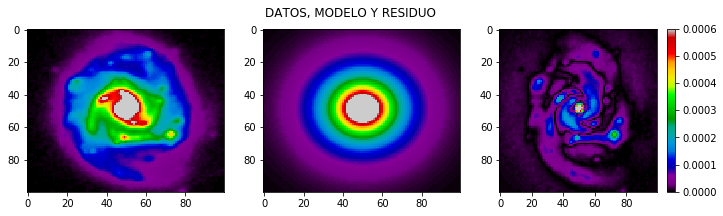

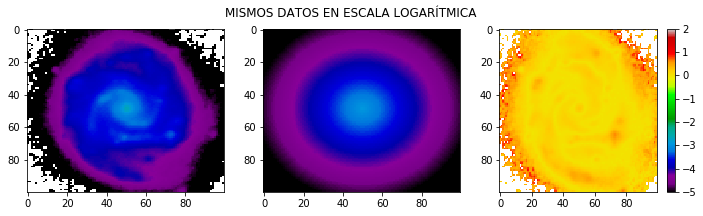

In [15]:
x0 = corte_A_2.shape[0]/2 # Da un punto en x inicial para que luego se optimice.
y0 = corte_A_2.shape[1]/2 # Da un punto inicial el y para optimizar.
A  = corte_A_2.max()
h  = 1 # Elije un valor a priori para la dispersión.
p0 = [x0,y0,A,h] # Pone los parámetros en un vector, (será un parámetro de las funciones siguientes).
best_params1,success = leastsq(ErrorFunc, p0, args = (corte_A_2)) # leastsq función que optimiza los parámetros.
g2 = make_inc_exponential(best_params1,corte_A_2)

# !!!!!!!!!!!!!!!!!!!!!!!!!!! PLOTEADA DE DATOS !!!!!!!!!!!!!!!!!!!!!!!!!!!
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('DATOS, MODELO Y RESIDUO')

plt.subplot(1, 3, 1)
plt.imshow(corte_A_2, vmin=0, vmax=0.0006, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(g2, vmin=0, vmax=0.0006, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(corte_A_2 - g2), vmin=0, vmax=0.0006, cmap='nipy_spectral', aspect='auto')
plt.colorbar()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('MISMOS DATOS EN ESCALA LOGARÍTMICA')

plt.subplot(1, 3, 1)
plt.imshow(np.log10(corte_A_2), vmin=-5, vmax=2, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(np.log10(g2), vmin=-5, vmax=2, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(np.log10(corte_A_2) - np.log10(g2)), vmin=-5, vmax=2, cmap='nipy_spectral', aspect='auto')
plt.colorbar()


In [16]:
best_params1

array([5.00550900e+01, 4.85273162e+01, 1.26828922e-03, 1.16012005e+01])

### A partir de los parámetros optimizados se puede obtener el modelo visto de frente, para de esa forma, proceder con los demás cálculos como el cálculo de la densidad superficial de brillo y la masa.

In [17]:
def make_exponential(tpl,image):  # Recibe un set de parámetros para hacer la gaussiana y el tamaño de la img.
    expo = np.zeros(image.size)   # Inicializa la matriz donde quedará la gaussiana.
    x = np.arange(image.shape[0]) # Toma el número de columnas de la matrz.imag y crea un arreglo x. 
    y = np.arange(image.shape[1]) # Toma el número de filas de la matrz.imag y crea un arreglo y.
    xx,yy = np.meshgrid(x,y)      # Crea la malla donde se pondrá la gaussiana.
    x0 = tpl[0] # Toma el primer valor del vector parámetros, y lo atribuye al centro de la función en x.
    y0 = tpl[1] # Toma el segundo valor del vector parámetros, y lo atribuye al centro de la función en y.
    A = tpl[2]  # Toma el tercer valor del vector parámetros, y lo atribuye a la aplitud de la función.
    h = tpl[3]  # Toma el cuarto valor del vector parámetros, y lo atribuye a la escala "h" de la función.
    expo = A*np.exp(-(np.sqrt((xx-x0)**2 + (yy-y0)**2))/h) # Se plantea la gaussiana.
    #expo = expo/expo.sum() # Se normaliza por el total de datos.
    return expo

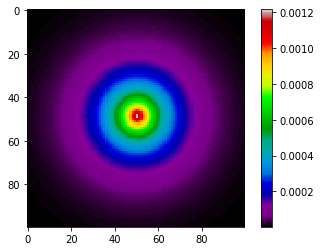

In [18]:
g1 = make_exponential(best_params1,corte_A_2)
plt.imshow(g1, cmap='nipy_spectral')
plt.colorbar()

### A mi parecer, es mejor utilizar el método de tomar una muestra de una región de fondo y hacer un histograma. Hay que recordar que el modelo no es perfectamente circular sino elipsoidal, y el primer método requiere determinar un radio fijo para truncar el modelo.

In [19]:
for i in np.arange(g3.shape[0]):
    for j in np.arange(g3.shape[1]):
        if g1[i,j] <= 1.77749382e-06:
            g1[i,j] = 0

## -------------------------------Ajuste de unidades del modelo -------------------------------

### Recordando que la cantidad almacenada en cada pixel es brillo, hay que ajustar las unidades para obtener el brillo superficial, no sin antes renormalizar el brillo para que se cumpla
$L_{total} = 10^{10} L_\odot$
### que es el orden de luminusidad de una galaxia.

In [20]:
g1.sum()

1.0188827888426086

In [21]:
g1 = g1/g1.sum()*10**10
g1.sum()

9999999999.999998

In [22]:
#plt.imshow(g1, cmap='nipy_spectral')
#plt.colorbar()

### Una vez ajustado el brillo, hay que ajustar la dimensión espacial para obtener la densidad de brillo superficial.
$100 \text{pxl} = 30000 \text{pc} \:\: \rightarrow \:\: 1 \text{pxl} = \frac{30000}{100} = 300 \text{pc}$

In [23]:
g0 = g1/300**2

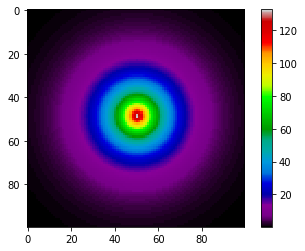

In [24]:
plt.imshow(g0, cmap='nipy_spectral')
plt.colorbar()

## ------------------------------ Cálculo de la masa de la galaxia ------------------------------

### Para estimar la masa de la galaxia hay que tener en cuenta la siguiente aproximación
$1 L_\odot \rightarrow 1M_\odot$
### por esta razón es conveniente usar el modelo $g1$, el cual almacena en cada pixel el brillo o luminosidad en ese espacio.

In [25]:
g1.sum()

9999999999.999998

### Entonces la masa de la galaxia es aproximadamente $10^{10} M_\odot$, lo cual es lógico debido a que se impuso la condición que la luminosidad total de la galaxia fuera $10^{10}L_\odot$. Implicitamente también se ajusto la masa. Aun así la distribución de masa varía de modelo a modelo, si se hace énfasis en la zona central de la galaxia, la masa es

In [47]:
g1[36:62, 37:64].sum() # Masa en la zona central de la galaxia.

3851379971.613082

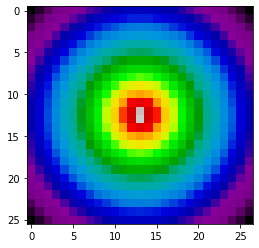

In [48]:
plt.imshow(g1[36:62, 37:64], cmap = 'nipy_spectral')